# Описание проекта

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. 

Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
### Задачи:
- Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. 
Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

- Проходным значением, чтобы считать проект успешным, будет значением F1-меры больше 0.59. 




In [133]:
import pandas as pd
import seaborn as sns # для графиков
from matplotlib import pyplot as plt # для графиков


from sklearn.tree import DecisionTreeClassifier # модель классификации
from sklearn.ensemble import RandomForestClassifier # модель классификации
from sklearn.linear_model import LogisticRegression # модель классификации

from sklearn.model_selection import train_test_split # разбивает на выборки


from sklearn.preprocessing import StandardScaler # для приведение к одному масштабу (масштабирование)
from sklearn.preprocessing import OrdinalEncoder #
from sklearn.metrics import (mean_absolute_error, 
                             precision_score ,
                             recall_score,
                             f1_score,
                             accuracy_score,
                             roc_curve,
                             roc_auc_score)


from sklearn.utils import shuffle # для перемешевания данных


import warnings
warnings.filterwarnings("ignore")

In [134]:
try:
    df = pd.read_csv('/datasets/Churn.csv')
except:
    df = pd.read_csv('Churn.csv')

## Описание данных

**Признаки**
-	RowNumber — индекс строки в данных
-	CustomerId — уникальный идентификатор клиента
-	Surname — фамилия
-	CreditScore — кредитный рейтинг
-	Geography — страна проживания
-	Gender — пол
-	Age — возраст
-	Tenure — сколько лет человек является клиентом банка
-	Balance — баланс на счёте
-	NumOfProducts — количество продуктов банка, используемых клиентом
-	HasCrCard — наличие кредитной карты
-	IsActiveMember — активность клиента
-	EstimatedSalary — предполагаемая зарплата

**Целевой признак**
-	Exited — **факт ухода клиента**


In [135]:
display(df)
df.info()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [136]:
df['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [137]:
df['CustomerId'].nunique()

10000

### Выводы:
- Столбец с признаком RowNumber отвечает за индекс строки в данных, что не имеет за собой смысла, просто дублирует, в дальнейшем скорее всего будем удалять;
- CustomerId — является идентификатором пользователя , все значения уникальны и не имеют дубликатов — стоблец также можно удалить;
- Surname —  не несет ценности для будущей модели — столбец можно удалять;
- В столбце признака 'Tenure' наблюдаются пропуски в размере 9% от общего количества строк в датасете;
- Сразу обратим внимание на **не** числовые признаки, Surname - фамилия клиента, Geography - страна проживания, Gender - пол;
- Из всех не числовых признаков будем приобразовывать в дальнейшем в числовой именно признак Gender и возможно Geography, так как 3 имеет всего три значения.


In [138]:
df.describe(include='all')

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000,10000.000000,10000,10000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
unique,NaN,NaN,2932,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Smith,NaN,France,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,32,NaN,5014,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5000.50000,1.569094e+07,NaN,650.528800,NaN,NaN,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,NaN,96.653299,NaN,NaN,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,NaN,350.000000,NaN,NaN,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,NaN,584.000000,NaN,NaN,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,NaN,652.000000,NaN,NaN,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,NaN,718.000000,NaN,NaN,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000


**Подитог:**

- кредитный рейтинг варьируется от 350 до 850;
- количество продуктов банка у одного клиента от 1 до 4;
- также есть признаки с булевым значением 0 или 1, это HasCrCard(наличие кредитной краты) и IsActiveMember(активность клиента).


In [139]:
df[['CreditScore','Age','Tenure',\
    'Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary','Exited']].corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
Balance,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
Exited,-0.027094,0.285323,-0.016761,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


**Подитог:** Прямой или обратной зависимости между признаками не наблюдается.

## Предобработка данных

In [140]:
# переведем названия колонок в нижний регистр и разделим слова знаком "_"
df.columns = df.columns.str.lower()
df = df.rename(columns={'rownumber':'row_number','customerid':'customer_id',\
                        'creditscore':'credit_score','numofproducts':'num_of_products',\
                        'hascrcard':'has_cr_card', 'isactivemember':'is_active_member',\
                        'estimatedsalary':'estimated_salary'})
df

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [141]:
# удалим столбец обозначающий индекс
del df['row_number']
del df['customer_id']
del df['surname']
df

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


<div class="alert alert-success">


    
Способ короче:
    
`data_ohe = df.drop(
    ['RowNumber', 'CustomerId', 'Surname'], axis=1
)`
</div> 

### Заполним пропуски 


In [142]:
df['tenure'].describe()

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: tenure, dtype: float64

In [143]:
df['tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64

### Вывод
- как можно увидеть среднее и медиана = **5**;
- значение 0 встречается реже остальных в 2 и более раза, кроме 10, предположение, что незаполненные поля = 0, не вижу логичным;
- корелляции с другими признаками также не наблюдается;
- логического решения данного вопроса не вижу

По той причине, что очевидной взаимосвязи пропусков в Tenure не наблюдается, удалим данные строки.

In [144]:
df = df.dropna()

In [145]:
df['tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64

***Подитог***:  количества людей являющихся клиентами банка распределена от 1 до 9 лет сбалансированно. 

В 2 раза меньше людей являющихся клиентов банка 10 лет и 0 лет. 

In [146]:
df['gender'].value_counts()

Male      4974
Female    4117
Name: gender, dtype: int64

In [147]:
# разобьем столбец gender на 2 численных, в одном будут мужчины в другом мужчины
data_ohe = pd.get_dummies(df['gender'],columns=['Gender_F', 'Gender_M'])
data_ohe.head(10)

,Female,Male
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
5,0,1
6,0,1
7,1,0
8,0,1
9,0,1


In [148]:
# Данные подготовим методом OHE, что позволит нам использовать разные модели и не попасть в дамми ловушку
df = pd.get_dummies(df, drop_first=True)
df

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9994,800,29,2.0,0.00,2,0,0,167773.55,0,0,0,0
9995,771,39,5.0,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10.0,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7.0,0.00,1,0,1,42085.58,1,0,0,0


### Вывод:

В новом датасете кол-во столбцов стало 12. Столбец Geography содержал 3 класса, Gender 2 класса — в результате мы получили только 2 и 1 столбцов соответственно, что позволяет избежать дами-ловушки.

In [149]:
# создадим новые столбцы
# df.loc[df['gender']=='Male', 'gender_male'] = 1
# df.loc[df['gender']=='Female', 'gender_female'] = 1

In [150]:
# заполним пропущенные значения в новых столбцах
# df['gender_male'] = df['gender_male'].fillna(0)
# df['gender_female'] = df['gender_female'].fillna(0)


In [151]:
# проверка 
df.head(10)


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0
5,645,44,8.0,113755.78,2,1,0,149756.71,1,0,1,1
6,822,50,7.0,0.00,2,1,1,10062.80,0,0,0,1
7,376,29,4.0,115046.74,4,1,0,119346.88,1,1,0,0
8,501,44,4.0,142051.07,2,0,1,74940.50,0,0,0,1
9,684,27,2.0,134603.88,1,1,1,71725.73,0,0,0,1


In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_score       9091 non-null   int64  
 1   age                9091 non-null   int64  
 2   tenure             9091 non-null   float64
 3   balance            9091 non-null   float64
 4   num_of_products    9091 non-null   int64  
 5   has_cr_card        9091 non-null   int64  
 6   is_active_member   9091 non-null   int64  
 7   estimated_salary   9091 non-null   float64
 8   exited             9091 non-null   int64  
 9   geography_Germany  9091 non-null   uint8  
 10  geography_Spain    9091 non-null   uint8  
 11  gender_Male        9091 non-null   uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 736.9 KB


**Итог:**
Данные готовы к использованию. Пропусков не наблюдается.

## Разобьем данные на выборки

In [153]:
encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(encoder.fit_transform(df), columns=df.columns) 


data_ordinal
# не вижу в этом коде смысла

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,226.0,24.0,2.0,0.0,0.0,1.0,1.0,4609.0,1.0,0.0,0.0,0.0
1,215.0,23.0,1.0,679.0,0.0,0.0,1.0,5119.0,0.0,0.0,1.0,0.0
2,109.0,24.0,8.0,5277.0,2.0,1.0,0.0,5182.0,1.0,0.0,0.0,0.0
3,306.0,21.0,1.0,0.0,1.0,0.0,0.0,4274.0,0.0,0.0,0.0,0.0
4,457.0,25.0,2.0,3374.0,0.0,1.0,1.0,3559.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9086,407.0,11.0,2.0,0.0,1.0,0.0,0.0,7599.0,0.0,0.0,0.0,0.0
9087,378.0,21.0,5.0,0.0,1.0,1.0,0.0,4385.0,0.0,0.0,0.0,1.0
9088,123.0,17.0,10.0,110.0,0.0,1.0,1.0,4627.0,0.0,0.0,0.0,1.0
9089,316.0,18.0,7.0,0.0,0.0,0.0,1.0,1882.0,1.0,0.0,0.0,0.0


In [154]:
features = df.drop('exited', axis=1) # Отберем НЕ ЦЕЛЕВЫЕ признаки
target = df['exited'] # ЦЕЛЕВОЙ ПРИЗНАК


#features = df.drop(['surname', 'customer_id', 'geography'], axis=1)  - пример удаления ненужных столбцов
# has_cr_card	is_active_member	 эти признаки имеют ответ да или нет (0 и 1)

### Проверка адекватности модели




Создадим константную модель и присвоим ей значение 0.

Для подсчёта классов в целевом признаке примените метод value_counts().

Значения сохраним в переменной class_frequency. 

Методом plot() c аргументом kind='bar' построим диаграмму

0    0.796062
1    0.203938
Name: exited, dtype: float64

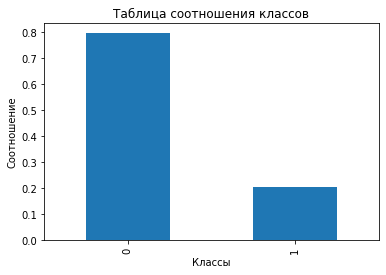

'Accuracy Score равен:'

0.7960620393796062

In [155]:
class_frequency = target.value_counts(normalize=True)
display(class_frequency)
class_frequency.plot(kind='bar',ylabel='Соотношение', xlabel='Классы',\
                     title = 'Таблица соотношения классов')

target_pred_constant = pd.Series([0] * len(target))
plt.show()
display('Accuracy Score равен:', accuracy_score(target, target_pred_constant)) 

**Подитог:** Классы несбалансированны, их соотношение далеко от 1:1.

Дисбаланс на лицо: **79%**

Баланс классов наблюдается, если их количество примерно равно. Accuracy не подходит. Нужна новая метрика!

Воспользуемся метрикой **F1**.

- создадим тренировочную выборку с 60% данных
- и 40% пока отводим на тестовую;

In [156]:
# разбиваем с сохранением изначального баланса классов 0 и 1 благодаря аргументу stratify = target
features_train,features_test, target_train, target_test = train_test_split(\
                        features, target, test_size=0.40, stratify = target , random_state=12345) 
print(features.shape)
print(target.shape)
print(features_train.shape)  # 60%
print(target_train.shape)    # 60%
print(features_test.shape)   # 40%
print(target_test.shape)     # 40%

(9091, 11)
(9091,)
(5454, 11)
(5454,)
(3637, 11)
(3637,)


- Делим тестовую выборку на 2 части , итого из 40% получаем 2 по 20%;

In [157]:
features_valid, features_test, target_valid, target_test  = train_test_split(\
                        features_test, target_test, test_size=0.50, random_state=12345) 

print(features.shape)
print(target.shape)
print(features_train.shape)   # 60%
print(target_train.shape)     # 60%
print(features_test.shape)    # 20%
print(target_test.shape)      # 20%
print(features_valid.shape)   # 20%
print(target_valid.shape)     # 20%

(9091, 11)
(9091,)
(5454, 11)
(5454,)
(1819, 11)
(1819,)
(1818, 11)
(1818,)


### Масштабирование — стандартизация данных

In [158]:
# создадим таблицу с численнымми признаками
numeric = ['credit_score','balance','num_of_products','age','estimated_salary'] 

In [159]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])


StandardScaler()

In [160]:
features_train[numeric] = scaler.transform(features_train[numeric]) # < масштабируем тренировочную выборку >
# < преобразуйте валидационную выборку >
features_valid[numeric] = scaler.transform(features_valid[numeric]) # < масштабируем валидационную выборку >
features_test[numeric] = scaler.transform(features_test[numeric]) # < масштабируем тестовую выборку >

In [161]:
# features_train_scaled = scaler.transform(features_train) # записи изменённых признаков
# features_valid_scaled = scaler.transform(features_valid) # записи изменённых признаков


In [162]:
#sns.scatterplot(data=df, x='credit_score',y='balance', hue=target)
#plt.show()

### Результат масшитабирования

In [163]:
# результат масшитабирования
display(features_train.head())

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
9723,-1.292898,-0.660843,7.0,0.786636,-0.910943,0,0,-0.223548,0,0,1
1224,-1.563714,0.778434,8.0,0.833795,-0.910943,1,0,1.383021,0,1,0
8377,1.581914,0.106771,4.0,-1.222967,0.789359,1,1,-0.308331,0,1,1
8014,0.842379,0.010820,2.0,0.807063,-0.910943,1,1,-0.430980,0,1,0
2491,-0.397123,-1.236554,4.0,-1.222967,0.789359,1,1,1.392642,0,1,0


## Исследуем модели машинного обучения не сбалансировав выборку

In [164]:
#Заранее напишем функцию для расчета полноты, точности и F1-меры
def RPF(target_valid, prediction):
    print("Полнота" , recall_score(target_valid, prediction))
    print("Точность", precision_score(target_valid, prediction))
    print("F1-мера", f1_score(target_valid, prediction))

In [165]:
#Заранее напишем функцию для создания графика ROC кривой
def plot_roc_curve(fper, tper, name):
    plt.plot(fper, tper, color='green', label='ROC')
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    plt.xlim([0.0, 1.0]) # обозначаем диапазон осей
    plt.ylim([0.0, 1.0]) # обозначаем диапазон осей
    plt.xlabel('False Positive Rate') # названия оси
    plt.ylabel('True Positive Rate') # названия оси
    plt.title('ROC-кривая '+ name)
    plt.legend()
    plt.show()

### Дерево решений

In [166]:
%%time


best_model_tree = None
best_result_tree = 0
best_depth_tree = 0
for depth in range(2, 20):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    model_tree.fit(features_train, target_train)
    predicted_valid_tree = model_tree.predict(features_valid) # получите предсказания модели
    f1_tree = f1_score(target_valid, predicted_valid_tree)
    if f1_tree > best_result_tree:
        best_model_tree = model_tree # сохраните наилучшую модель
        best_result_tree = f1_tree #  сохраните наилучшее значение метрики accuracy на валидационных данных
        best_depth_tree = depth
print("F1 наилучшей модели на валидационной выборке:", best_result_tree)
print("Глубина наилучшей модели на валидационной выборке:", best_depth_tree) 

F1 наилучшей модели на валидационной выборке: 0.603648424543947
Глубина наилучшей модели на валидационной выборке: 7
CPU times: user 382 ms, sys: 14 µs, total: 382 ms
Wall time: 385 ms


### Обучим модель на лучшем результате с глубиной решающего дерева = 7

In [167]:
best_of_the_model_tree = DecisionTreeClassifier(random_state=12345, max_depth=7) 
best_of_the_model_tree.fit(features_train, target_train)
predicted_valid_best_of_the_best = best_of_the_model_tree.predict(features_valid) # получите предсказания модели

In [168]:
# рассчитаем RPF
RPF(target_valid, predicted_valid_best_of_the_best)

Полнота 0.48533333333333334
Точность 0.7982456140350878
F1-мера 0.603648424543947


### Немного о ROC_AUC и расчете ее площади

Площадь под кривой (AUC) является мерой способности классификатора различать классы. Чем выше площадь под кривой, тем лучше производительность модели.

Когда AUC равен единице, тогда классификатор может правильно различать все положительные и отрицательные точки класса:

Когда 0,5 < AUC < 1, высока вероятность, что классификатор сможет различить положительные и отрицательных значения класса. Это так, потому что классификатор может обнаруживать больше истинно положительных и истинно отрицательных результатов, чем ложно отрицательных и ложно положительных результатов:


Когда AUC = 0,5, тогда классификатор не может различать положительные и отрицательные баллы класса. Это означает, что либо классификатор предсказывает случайный класс, либо существует один постоянный класс для всех точек данных:


Таким образом, чем выше значение AUC для классификатора, тем лучше его способность различать положительные и отрицательные классы.

Площадь ROC_AUC =  0.825005313005313


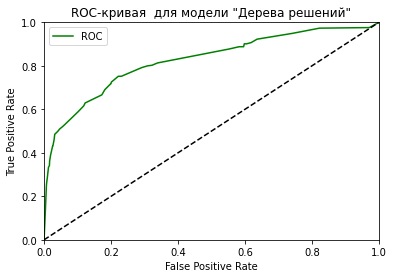

In [169]:
#Расчет площади ROC_AUC для дерева решений
probabilities_one_valid_tree = best_of_the_model_tree.predict_proba(features_valid)[:, 1]

auc_roc_tree = roc_auc_score(target_valid, probabilities_one_valid_tree)
print('Площадь ROC_AUC = ', auc_roc_tree)


fper, tper, thresholds = roc_curve(target_valid, probabilities_one_valid_tree)
plot_roc_curve(fper, tper, ' для модели "Дерева решений"')

**Вывод:** 

Дерево решений на не сбалансированной выборке показывает отличный результат:
- F-меры = 0.6036;
- площади ROC_AUC = 0.8250;
- Однако полнота имеет не высокий показатель 0.48.

Напомним площаль ROC_AUC выше 0.5 считается хорошим результатам.

### Случайный лес

In [170]:
%%time


best_model_forest = None
best_result_forest = 0
best_est_forest = 0
best_depth_forest = 0
for est in range(10, 80, 10): # кол-во деревьев с шагом 10
    for depth in range (1, 20): # количество вопросов (глубина)
        model_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) # обучите модель с заданным количеством деревьев
        model_forest.fit(features_train,target_train ) # обучите модель на тренировочной выборке
        predicted_valid_forest = model_forest.predict(features_valid)
        f1_forest = f1_score(target_valid, predicted_valid_forest) # посчитайте качество модели на валидационной выборке
        if f1_forest > best_result_forest:
            best_model_forest = model_forest # сохраните наилучшую модель
            best_result_forest = f1_forest #  сохраните наилучшее значение метрики на валидационных данных
            best_depth_forest = depth
            best_est_forest = est
print("F1 наилучшей модели на валидационной выборке:", best_result_forest)
print("Глубина наилучшей модели на валидационной выборке:", best_depth_forest)
print("Количество деревье наилучшей модели на валидационной выборке:", best_est_forest)


F1 наилучшей модели на валидационной выборке: 0.6123778501628665
Глубина наилучшей модели на валидационной выборке: 13
Количество деревье наилучшей модели на валидационной выборке: 70
CPU times: user 26.9 s, sys: 147 ms, total: 27.1 s
Wall time: 27.1 s


Полнота 0.5013333333333333
Точность 0.7866108786610879
F1-мера 0.6123778501628665
Площадь AUR_ROC =  0.8625317625317624


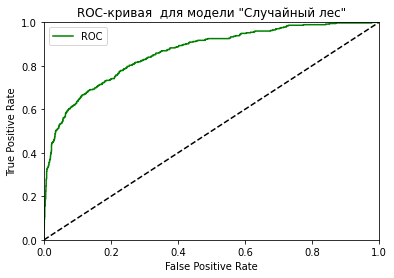

In [171]:
best_of_the_model_forest = RandomForestClassifier(random_state=12345, n_estimators=70, max_depth = 13) 
best_of_the_model_forest.fit(features_train, target_train)
predicted_valid_best_of_the_forest = best_of_the_model_forest.predict(features_valid) # получите предсказания модели

# рассчитаем RPF
RPF(target_valid, predicted_valid_best_of_the_forest)

#Расчет roc_auc для дерева решений
probabilities_one_valid_forest = best_of_the_model_forest.predict_proba(features_valid)[:, 1]

auc_roc_tree = roc_auc_score(target_valid, probabilities_one_valid_forest)
print('Площадь AUR_ROC = ', auc_roc_tree)


fper_1, tper_1, thresholds = roc_curve(target_valid, probabilities_one_valid_forest)
plot_roc_curve(fper_1, tper_1,' для модели "Случайный лес"')

**Вывод:** 

Случайный лес на не сбалансированной выборке показывает отличный результат:
- F-меры = 0.6123;
- площади ROC_AUC = 0.8625, что существенно лучше чем на моделе дерева решений;
- Однако полнота имеет по прежнему не высокий показатель - 0.50.



### Логистическая регрессия

In [172]:

model_log = LogisticRegression(random_state=12345,  solver='liblinear')
model_log.fit(features_train, target_train) # обучаем на новых данных
predicted_valid_log = model_log.predict(features_valid) # подставляем в прогноз валидационные нецелевые признаки

# рассчитаем RPF
RPF(target_valid, predicted_valid_log)

Полнота 0.232
Точность 0.635036496350365
F1-мера 0.33984375000000006


Площадь AUR_ROC =  0.7831628551628552


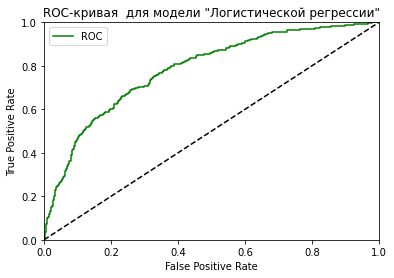

In [173]:
probabilities_valid = model_log.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]


# Расчет roc_auc площади для логистической регрессии
auc_roc_tree = roc_auc_score(target_valid, probabilities_one_valid)
print('Площадь AUR_ROC = ', auc_roc_tree)

# Построим график
fper_2, tper_2, thresholds = roc_curve(target_valid, probabilities_one_valid)
plot_roc_curve(fper_2, tper_2,' для модели "Логистической регрессии"')



ROC - кривая  или кривая ошибок стремится вверх, это положительная черта говорящая о хорошем качестве 

Чем график выше, тем больше значение TPR и лучше качество модели.

**Вывод:** 

Случайный лес на не сбалансированной выборке показывает плохой результат:
- F-меры = 0.3398;
- Полнота также имеет крайне низкий показатель - 0.232.
- Однако как не парадаксально площадь ROC_AUC = 0.7831;

## Вывод:
В результате 2 модели из трех дали результат, который удовлетворяет решение нашего проекта:

1) Наилучший результат у модели случайный лес - RandomForestClassifier. F-мера равна =0.6123;

2) Следующий результат у решающего дерева - DecisionTreeClassifier. F-мера у данной модели равна 0.6036;

3) 3-й результат дает логистическая регрессия - LogisticRegression. F-мера у данной модели равна 0.3398, что нам никак не подходит.


# Исследуем модели машинного обучения сбалансировав классы

Как мы выяснили ранее в нашей выборке отрицательны ответов ≈79% , положитительных ≈ 19%. Нам необходмо увеличить количество положительных ответов в 4 раза для достижения баланса. Либо же уменьшить кол-во отрицтаельных ответов.

- Разделим обучающую выборку на отрицательные и положительные объекты;
- Скопируем несколько раз положительные объекты; 
- С учётом полученных данных создадим новую обучающую выборку; 
- Перемешаем данные: идущие друг за другом одинаковые вопросы не помогут обучению. 

### Обучим новые модели

### Используем увеличение выборки благодаря методу upsampling

In [174]:
features_zeros = features_train[target_train == 0]
features_ones = features_train[target_train == 1]
target_zeros = target_train[target_train == 0]
target_ones = target_train[target_train == 1]

repeat = 4
features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
target_upsampled = pd.concat([target_zeros]+ [target_ones]* repeat, )
print(features_upsampled.shape)
print(target_upsampled.shape)




(8790, 11)
(8790,)


In [175]:
def upsample(features, target, repeat):
# создаем новые переменные по фильтру, целевому признаку
    features_zeros = features[target == 0] 
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

# объединяем и умножаем, расширяем одним словом
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
# перемешиваем
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled 

# применяем функцию
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

### Дерево решений с использованием upsampling

In [176]:
%%time


best_model_tree_2 = None
best_result_tree_2 = 0
best_depth_tree_2 = 0
for depth in range(2, 20):
    model_tree_2 = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    model_tree_2.fit(features_upsampled, target_upsampled)
    predicted_valid_tree_2 = model_tree_2.predict(features_valid) # получите предсказания модели
    f1_tree_2 = f1_score(target_valid, predicted_valid_tree_2)
    if f1_tree_2 > best_result_tree_2:
        best_model_tree_2 = model_tree_2 # сохраните наилучшую модель
        best_result_tree_2 = f1_tree_2 #  сохраните наилучшее значение метрики accuracy на валидационных данных
        best_depth_tree_2 = depth
print("F1 наилучшей модели на валидационной выборке:", best_result_tree_2)
print("Глубина наилучшей модели на валидационной выборке:", best_depth_tree_2) 

F1 наилучшей модели на валидационной выборке: 0.5804347826086956
Глубина наилучшей модели на валидационной выборке: 8
CPU times: user 551 ms, sys: 0 ns, total: 551 ms
Wall time: 562 ms


In [177]:
best_of_the_model_tree_balance = DecisionTreeClassifier(random_state=12345, max_depth=8) 
best_of_the_model_tree_balance.fit(features_upsampled, target_upsampled)
predicted_valid_best_of_the_best_balance = best_of_the_model_tree_balance.predict(features_valid) # получите предсказания модели

In [178]:
#Расчет площади ROC_AUC для дерева решений
probabilities_one_valid_tree_balance = best_of_the_model_tree_balance.predict_proba(features_valid)[:, 1]

auc_roc_tree = roc_auc_score(target_valid, probabilities_one_valid_tree_balance)
print('Площадь ROC_AUC = ', auc_roc_tree)

Площадь ROC_AUC =  0.8192783552783552


In [179]:
# рассчитаем RPF
RPF(target_valid, predicted_valid_best_of_the_best_balance)

Полнота 0.712
Точность 0.48990825688073397
F1-мера 0.5804347826086956


**Подитог**:

В результате произошло:
- спад показателя F-меры –  он упал с 0.6036 до 0.58;
- упал показатель точности - с 0.79 до 0.49;
- но при этом вырос показатель полноты с 0.485 до 0.712.
- и незначительно выросла площадь ROC_AUC, с 0.81 до 0.819


После балансирования классов за счет увеличения выборки предсказания качества решающего дерева упало в точности и в F-мере.

### Случайный лес с использованием upsampling

In [180]:
%%time




best_model_forest_2 = None
best_result_forest_2 = 0
best_est_forest_2 = 0
best_depth_forest_2 = 0
for est in range(10, 80, 10): # кол-во деревьев с шагом 10
    for depth in range (1, 20): # количество вопросов (глубина)
        model_forest_2 = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) # обучите модель с заданным количеством деревьев
        model_forest_2.fit(features_upsampled, target_upsampled ) # обучите модель на тренировочной выборке
        predicted_valid_forest_2 = model_forest_2.predict(features_valid)
        f1_forest_2 = f1_score(target_valid, predicted_valid_forest_2) # посчитайте качество модели на валидационной выборке
        if f1_forest_2 > best_result_forest_2:
            best_model_forest_2 = model_forest_2 # сохраните наилучшую модель
            best_result_forest_2 = f1_forest_2 #  сохраните наилучшее значение метрики на валидационных данных
            best_depth_forest_2 = depth
            best_est_forest_2 = est
print("F1 наилучшей модели на валидационной выборке:", best_result_forest_2)
print("Глубина наилучшей модели на валидационной выборке:", best_depth_forest_2)
print("Количество деревье наилучшей модели на валидационной выборке:", best_est_forest_2)


F1 наилучшей модели на валидационной выборке: 0.6311688311688313
Глубина наилучшей модели на валидационной выборке: 12
Количество деревье наилучшей модели на валидационной выборке: 40
CPU times: user 36.9 s, sys: 179 ms, total: 37.1 s
Wall time: 37.1 s


In [181]:
best_of_the_model_forest_balance = RandomForestClassifier(random_state=12345, n_estimators=40, max_depth = 12) 
best_of_the_model_forest_balance.fit(features_upsampled, target_upsampled)
predicted_valid_best_of_the_forest_balance = best_of_the_model_forest_balance.predict(features_valid) # получите предсказания модели

In [182]:
#Расчет roc_auc для случайного леса
probabilities_one_valid_forest_balance = best_of_the_model_forest_balance.predict_proba(features_valid)[:, 1]

auc_roc_tree = roc_auc_score(target_valid, probabilities_one_valid_forest_balance)
print('Площадь AUR_ROC = ', auc_roc_tree)


Площадь AUR_ROC =  0.8587424347424347


In [183]:
# рассчитаем RPF
RPF(target_valid, predicted_valid_best_of_the_forest_balance)

Полнота 0.648
Точность 0.6151898734177215
F1-мера 0.6311688311688313


**Подитог**:
Случайный лес на сбалансированной выборке показывает следующие результаты:
- F-мера показала не большой рост –  выросла с 0.6123 до 0.6311
- площадь ROC_AUC стала немного хуже, упав с 0.8625 до 0.8526



### Логистическая регрессия с использованием upsampling

In [184]:

model_log_2 = LogisticRegression(random_state=12345,  solver='liblinear')
model_log_2.fit(features_upsampled, target_upsampled) # обучаем на новых данных
predicted_valid_log_2 = model_log_2.predict(features_valid) # подставляем в прогноз валидационные нецелевые признаки

precision_log_2 = precision_score(target_valid, predicted_valid_log_2)
recall_log_2 = recall_score(target_valid, predicted_valid_log_2)
print("Полнота:", recall_log_2)
print("Точность:", precision_log_2)
print("F1:", f1_score(target_valid, predicted_valid_log_2))


Полнота: 0.72
Точность: 0.39416058394160586
F1: 0.5094339622641509


In [185]:
model_log_balance = LogisticRegression(random_state=12345,  solver='liblinear')
model_log_balance.fit(features_upsampled, target_upsampled)
predicted_valid_log_balance = model_log_balance.predict(features_valid) # получите предсказания модели
#Расчет roc_auc для  логистической регрессии
probabilities_one_valid_log_balance = model_log_balance.predict_proba(features_valid)[:, 1]

auc_roc_tree = roc_auc_score(target_valid, probabilities_one_valid_log_balance)
print('Площадь AUR_ROC = ', auc_roc_tree)

Площадь AUR_ROC =  0.7880397320397321


**Подитог**:

Метрика показала рост – это уже можно назвать успехом, хотя и показатель не достиг уровня нашей цели в 0.59.

F-мера стала = 0.509. То есть выросла на 0.16. Напоминим, предудущий показатель был равен: 0.3398

Также площадь AUR_ROC незначительно, но выросла с 0.7832 до 0.788

## Вывод:
В результате только 1 модель из трех дала нужный результат на сбалансированной выборке с помощью upsampling:

1) Наилучший результат у модели случайный лес - RandomForestClassifier. F-мера равна =0.631;

2) Следующий результат у решающего дерева - DecisionTreeClassifier. F-мера у данной модели равна 0.58;

3) 3-й результат дает логистическая регрессия - LogisticRegression. F-мера у данной модели равна 0.509, что нам никак не подходит.


### Используем уменьшение выборки благодаря методу downsampling 

Преобразование проходит в несколько этапов:

•	Разделить обучающую выборку на отрицательные и положительные объекты;

•	Случайным образом отбросить часть из отрицательных объектов;

•	С учётом полученных данных создать новую обучающую выборку;

•	Перемешать данные. Положительные не должны идти следом за отрицательными: алгоритмам будет сложнее обучаться.


In [186]:
print(features_train.shape)

features_sample = features_train.sample(frac=0.25, random_state=12345)
print(features_sample.shape)



(5454, 11)
(1364, 11)


In [187]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    
    target_downsampled =pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones]) 
# объединяем таргеты и берем долю от них тем самым уменьшая выборку
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345) # перемешиваем

    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

print(features_downsampled.shape)
print(target_downsampled.shape)


(2198, 11)
(2198,)


### Дерево решений с использованием downsampling

In [188]:
%%time


best_model_tree_3 = None
best_result_tree_3 = 0
best_depth_tree_3 = 0
for depth in range(3, 20):
    model_tree_3 = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    model_tree_3.fit(features_downsampled, target_downsampled)
    predicted_valid_tree_3 = model_tree_3.predict(features_valid) # получите предсказания модели
    f1_tree_3 = f1_score(target_valid, predicted_valid_tree_3)
    if f1_tree_3 > best_result_tree_3:
        best_model_tree_3 = model_tree_3 # сохраните наилучшую модель
        best_result_tree_3 = f1_tree_3 #  сохраните наилучшее значение метрики accuracy на валидационных данных
        best_depth_tree_3 = depth
print("F1 наилучшей модели на валидационной выборке:", best_result_tree_3)
print("Глубина наилучшей модели на валидационной выборке:", best_depth_tree_3) 

F1 наилучшей модели на валидационной выборке: 0.5702479338842975
Глубина наилучшей модели на валидационной выборке: 8
CPU times: user 187 ms, sys: 7.88 ms, total: 194 ms
Wall time: 197 ms


In [199]:
best_of_the_model_tree_balance_2 = DecisionTreeClassifier(random_state=12345, max_depth=8) 
best_of_the_model_tree_balance_2.fit(features_downsampled, target_downsampled)
predicted_valid_best_of_the_best_balance_2 = best_of_the_model_tree_balance_2.predict(features_valid) # получите предсказания модели

In [200]:
#Расчет площади ROC_AUC для дерева решений
probabilities_one_valid_tree_balance_2 = best_of_the_model_tree_balance_2.predict_proba(features_valid)[:, 1]

auc_roc_tree = roc_auc_score(target_valid, probabilities_one_valid_tree_balance_2)
print('Площадь ROC_AUC = ', auc_roc_tree)

Площадь ROC_AUC =  0.8217666897666898


In [201]:
# рассчитаем RPF
RPF(target_valid, predicted_valid_best_of_the_best_balance_2)

Полнота 0.736
Точность 0.4654300168634064
F1-мера 0.5702479338842975


### Случайный лес с использованием downsampling

In [192]:
%%time




best_model_forest_3 = None
best_result_forest_3 = 0
best_est_forest_3 = 0
best_depth_forest_3 = 0
for est in range(10, 80, 10): # кол-во деревьев с шагом 10
    for depth in range (1, 20): # количество вопросов (глубина)
        model_forest_3 = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) # обучите модель с заданным количеством деревьев
        model_forest_3.fit(features_downsampled, target_downsampled ) # обучите модель на тренировочной выборке
        predicted_valid_forest_3 = model_forest_3.predict(features_valid)
        f1_forest_3 = f1_score(target_valid, predicted_valid_forest_3) # посчитайте качество модели на валидационной выборке
        if f1_forest_3 > best_result_forest_3:
            best_model_forest_3 = model_forest_3 # сохраните наилучшую модель
            best_result_forest_3 = f1_forest_3 #  сохраните наилучшее значение метрики на валидационных данных
            best_depth_forest_3 = depth
            best_est_forest_3 = est
print("F1 наилучшей модели на валидационной выборке:", best_result_forest_3)
print("Глубина наилучшей модели на валидационной выборке:", best_depth_forest_3)
print("Количество деревье наилучшей модели на валидационной выборке:", best_est_forest_3)


F1 наилучшей модели на валидационной выборке: 0.6058002148227712
Глубина наилучшей модели на валидационной выборке: 9
Количество деревье наилучшей модели на валидационной выборке: 40
CPU times: user 15.7 s, sys: 91.5 ms, total: 15.8 s
Wall time: 15.8 s


In [193]:
model_forest_best = RandomForestClassifier(random_state=12345, n_estimators=40, max_depth=9)
model_forest_best.fit(features_downsampled, target_downsampled ) # обучите модель на тренировочной выборке
predicted_valid_forest_best = model_forest_best.predict(features_valid)
    


In [194]:
#Расчет roc_auc для случайного леса
probabilities_one_valid_forest_balance_2 = model_forest_best.predict_proba(features_valid)[:, 1]

auc_roc_tree = roc_auc_score(target_valid, probabilities_one_valid_forest_balance_2)
print('Площадь AUR_ROC = ', auc_roc_tree)


Площадь AUR_ROC =  0.8641090321090321


In [195]:
# рассчитаем RPF
RPF(target_valid, predicted_valid_forest_best)

Полнота 0.752
Точность 0.5071942446043165
F1-мера 0.6058002148227712


### Логистическая регрессия с использованием downsampling

In [196]:
model_log_3 = LogisticRegression(random_state=12345,  solver='liblinear')
model_log_3.fit(features_downsampled, target_downsampled) # обучаем на новых данных
predicted_valid_log_3 = model_log_3.predict(features_valid) # подставляем в прогноз валидационные нецелевые признаки

precision_log_3 = precision_score(target_valid, predicted_valid_log_3)
recall_log_3 = recall_score(target_valid, predicted_valid_log_3)
print("Полнота:", recall_log_3)
print("Точность:", precision_log_3)
print("F1:", f1_score(target_valid, predicted_valid_log_3))

Полнота: 0.736
Точность: 0.3994211287988423
F1: 0.5178236397748592


In [197]:
model_log_balance_2 = LogisticRegression(random_state=12345,  solver='liblinear')
model_log_balance_2.fit(features_downsampled, target_downsampled)
predicted_valid_log_balance_2 = model_log_balance_2.predict(features_valid) # получите предсказания модели
#Расчет roc_auc для  логистической регрессии
probabilities_one_valid_log_balance_2 = model_log_balance_2.predict_proba(features_valid)[:, 1]

auc_roc_tree = roc_auc_score(target_valid, probabilities_one_valid_log_balance_2)
print('Площадь AUR_ROC = ', auc_roc_tree)

Площадь AUR_ROC =  0.7892834372834374


## Вывод: 
С уменьшением выборки данных через метод downsampling с аргументом frac=0.25, результаты на моделе "Случайный лес" и "Решающее дерево" показали ухудшение результатов.

- По моделе "Случайный лес" показатель F-меры также незначительно, но упал с 0.612 до 0.605 
- А по моделе "Дерева Решений" показатель и вовсе упал за рамки допустимых значений F-меры с 0.60 до 0.57



Ввиду этого можем сделать вывод, для данной выборки лучше всего использовать балансирование классов через метод upsampling, увеличением выборки меньшего класса в 4 раза. 

Благодаря данному методу мы добились улучшения показателей F-меры:
-  у Случайного леса показатель вырос с **0.61 до 0.63**;
-  у Дерева решений показатель немного стал ниже, был 0.60, стал 0.58 - что также лучше чем использования предыдущего класса;
- и наибольший прирост полуился модель Логистической регрессии, ее показател был 0.34 и вырос до 0.51, однако эта модель нам в любом случаи не подходит, так как результат ниже 0.59.

При всем при этом показатель площади AUR_ROC находится в высоких значениях на всех моделях, от 0.75 до 0.86

Как итог, для тестовой выборки лучше всего подойдет модель **RandomForestClassifier**.


# ИТОГ: 

В результате проекта, для данной выборки лучше всего подходит:

1) Модель **RandomForestClassifier**, с параметрами
- деревья (n_estimators) = 40
- глубиной (max_depth) = 12

2) Метод борьбы с дисбалансом -  upsampling, увеличением выборки меньшего класса в 4 раза.


Благодаря данным параметрам мы добились лучшего результата F-меры. 

Проверим гипотезу на тестовой выборке.

## Проверим модель на тестовой выборке

***Из трех моделей лучший результат показала модель - RandomForestClassifier. На ней и проверим тестовую выборку:***

In [202]:
# feature_all = pd.concat([features_train, features_valid], ignore_index=True) # объединили и индексы занова пронумировали
# target_all = pd.concat([target_train, target_valid], ignore_index=True) # объединили по таргетам
model_test = RandomForestClassifier(random_state=12345, n_estimators=40, max_depth = 12)
model_test.fit(features_upsampled, target_upsampled)
predict1 = model_test.predict(features_test)
f_1_result = f1_score(predict1, target_test)



print("F-мера наилучшей модели на тестовой выборке:", f_1_result)

F-мера наилучшей модели на тестовой выборке: 0.6131191432396251


### Итоговый результат предсказания качества модели выше 59%, цель проекта выполнена.   

# Выводы
В первоначальные данных наблюдался  дисбаланс (79% ответов целевого признака были негативными и только 21% позитивными), из-за чего обученная на этих данных модель не проходила проверку на адекватность. 
Однако на первоначальных данных с такой диспропорцией классов модель "Решающее Дерево" и "Случайный лес" уже давали референсные значения F1-меры с показателями 0.60 и 0.61 соответственно. 

Для улучшения результата устанирили дисбаланс классов в обучающей выборке благодаря увеличению объема данных в 4 раза и перемешке их.


На новых данных 2 модели из 3 показали результат выше, чем на несбалансированной выборке. 

Лучшие показатели были у модели случайного леса (**RandomForestClassifier**
):

Полнота   0.648

Точность  0.615

F1-мера   0.631



